# Paper Analysis

This notebook generates the graphs contained within the paper. It should all just run 🤞

(Make sure you've filled out the config file and unzipped the results if you decide to run it.)

## Loading in the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
import numpy as np
import json

from matplotlib.lines import Line2D
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from mp_sampling import get_ce_mean_and_std, plot_group_similarity_across_runs_simple, plot_group_similarity_across_runs_stepped, get_CE_means_fixed_windows
from analysis_functions import highlight_significant_windows, highlight_significant_changes, get_significant_windows, plot_hlines

with open("../project-config.json") as config_file:
    project_config = json.load(config_file)
    
results_fp = project_config["RESULTS_DIR_ALL"]
results_fp_eu = project_config["RESULTS_DIR_EU"]
out_fp = project_config["GRAPHS_DIR"]

kw_dir = project_config["KW_DIR"]

In [2]:
def get_CE_comparisons(fp):
    with open(fp) as results_file:
        results = json.load(results_file)

    comparisons = [{gsnap: {gtest: {datetime.strptime(w, "%Y-%m-%d"): pd.Series(run[gsnap][gtest][w]) for w in run[gsnap][gtest]} for gtest in run[gsnap]} for gsnap in run} for run in results["comparisons"]]
    return comparisons

def get_ends_of_windows(fp):
    with open(fp) as results_file:
        results = json.load(results_file)
            
    return [datetime.strptime(w, "%Y-%m-%d") for w in results["end_of_windows"]] 

def plot_significant_changes(curr_runs, curr_end_dates, ax, colour):
    curr_2nd = curr_runs.iloc[1:]
    curr_1st = curr_runs.iloc[:-1].set_index(curr_2nd.index)
    significant_changes = get_significant_windows(curr_2nd, curr_1st, curr_end_dates[1:])
    plot_hlines(significant_changes, ax, colour)

## Do Remainer MPs from Leave Constituencies become more similar to Leavers after the Referendum?

In [3]:
comparisons = get_CE_comparisons(os.path.join(results_fp, "remain_constituency.json"))
end_dates = get_ends_of_windows(os.path.join(results_fp, "remain_constituency.json"))

leaver_r_con_runs = get_CE_means_fixed_windows(comparisons, "Leavers", "Remain_Constituency_Remainers")
leaver_l_con_runs = get_CE_means_fixed_windows(comparisons, "Leavers", "Leave_Constituency_Remainers")

leaver_leaver_runs = get_CE_means_fixed_windows(comparisons, "Leavers", "Leavers")

leaver_r_con_means, leaver_r_con_stds = get_ce_mean_and_std(comparisons, "Leavers", "Remain_Constituency_Remainers")
leaver_l_con_means, leaver_l_con_stds = get_ce_mean_and_std(comparisons, "Leavers", "Leave_Constituency_Remainers")

leaver_leaver_means, leaver_leaver_stds = get_ce_mean_and_std(comparisons, "Leavers", "Leavers")

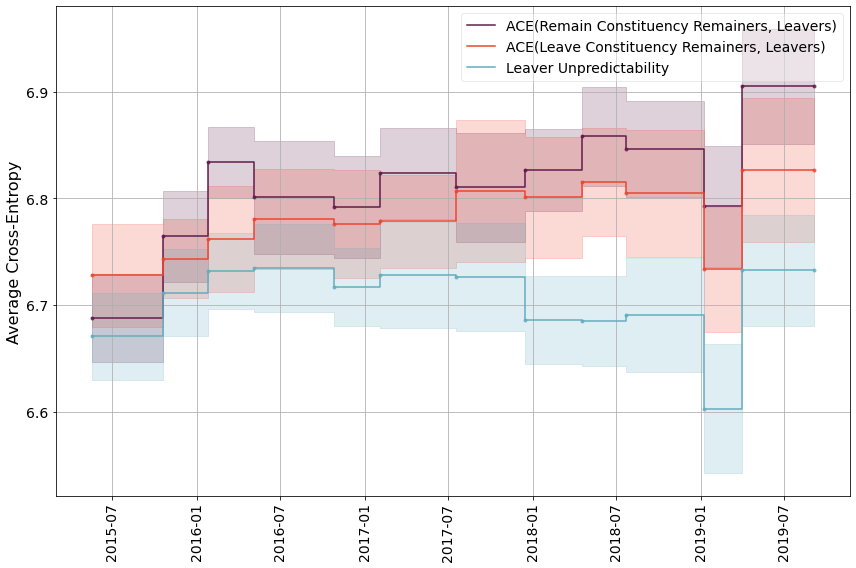

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#601A4A", "#EE442F", "#63ACBE"]

plot_group_similarity_across_runs_stepped(leaver_r_con_means, leaver_r_con_stds, ax, colour=colour_list[0], label='ACE(Remain Constituency Remainers, Leavers)', fill_alpha=0.2, end_dates=end_dates)

plot_group_similarity_across_runs_stepped(leaver_l_con_means, leaver_l_con_stds, ax, colour=colour_list[1], label='ACE(Leave Constituency Remainers, Leavers)', fill_alpha=0.2, end_dates=end_dates)

plot_group_similarity_across_runs_stepped(leaver_leaver_means, leaver_leaver_stds, ax, colour=colour_list[2], label='Leaver Unpredictability', fill_alpha=0.2, end_dates=end_dates)

ax.set_ylabel("Average Cross-Entropy", fontsize=16)

ax.grid()

ax.legend(fontsize=14, framealpha=0.4)

ax.tick_params(labelsize=14)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "remainer_constituency_ce.pdf"))

plt.show()

The above graph suggests that for the most part there isn't much of an increase in divergence from either group.
We can get a slightly better impression if we plot the difference between remainer CE and leaver unpredictability.
Here we are treating the leaver unpredictability as a baseline.

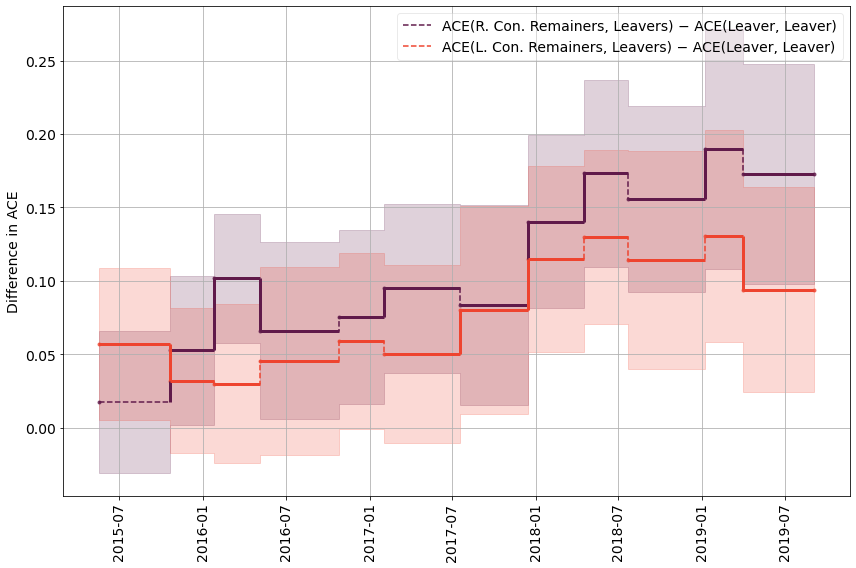

In [5]:
leaver_r_con_diff = leaver_r_con_runs - leaver_leaver_runs
leaver_l_con_diff = leaver_l_con_runs - leaver_leaver_runs

fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#601A4A", "#EE442F", "#63ACBE"]

means = leaver_r_con_diff.mean(axis=1)
stds = leaver_r_con_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax, colour=colour_list[0], label="ACE(R. Con. Remainers, Leavers) − ACE(Leaver, Leaver)", line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=end_dates)
highlight_significant_changes(leaver_r_con_diff, end_dates, ax, colour_list[0], line_alpha=0)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(leaver_r_con_runs, leaver_leaver_runs, end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax, colour_list[0])

means = leaver_l_con_diff.mean(axis=1)
stds = leaver_l_con_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax, colour=colour_list[1], label="ACE(L. Con. Remainers, Leavers) − ACE(Leaver, Leaver)", line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=end_dates)
highlight_significant_changes(leaver_l_con_diff, end_dates, ax, colour_list[1], line_alpha=0)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(leaver_l_con_runs, leaver_leaver_runs, end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax, colour_list[1])


ax.set_ylabel("Difference in ACE", fontsize=14)

ax.grid()
ax.tick_params(labelsize=14)
ax.legend(fontsize=14, framealpha=0.4)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "Remainer_Constituency_Differences.pdf"))

plt.show()

Now we can see that remainers from remain constituencies begin to diverge compared to those from leave constituencies towards the end of the time span.

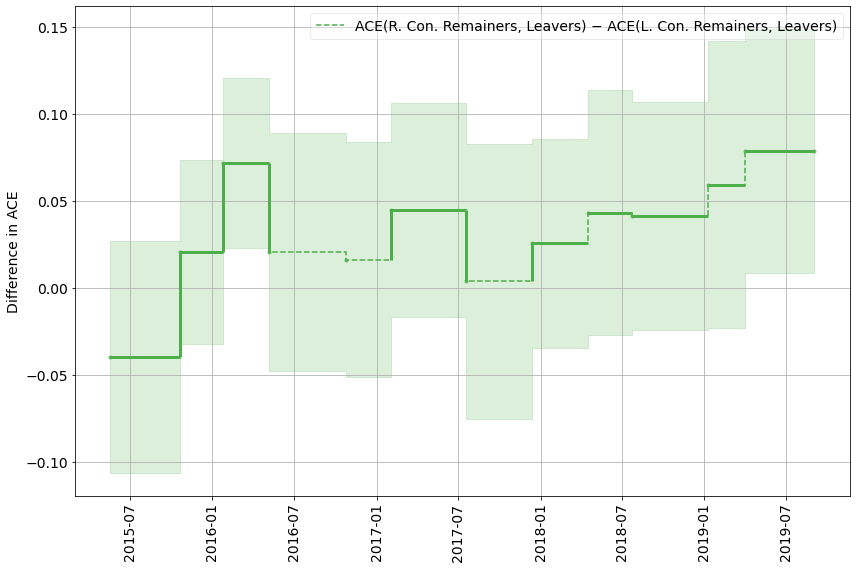

In [6]:
leaver_r_con_diff = leaver_r_con_runs - leaver_l_con_runs

fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"]

means = leaver_r_con_diff.mean(axis=1)
stds = leaver_r_con_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax, colour=colour_list[2], label="ACE(R. Con. Remainers, Leavers) − ACE(L. Con. Remainers, Leavers)", line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=end_dates)
highlight_significant_changes(leaver_r_con_diff, end_dates, ax, colour_list[2], line_alpha=0)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(leaver_r_con_runs, leaver_l_con_runs, end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax, colour_list[2])

ax.set_ylabel("Difference in ACE", fontsize=14)

ax.grid()
ax.tick_params(labelsize=14)
ax.legend(fontsize=14, framealpha=0.4)

plt.tight_layout()

# fig.savefig(os.path.join(out_fp, "Remainer_Constituency_Differences.pdf"))

plt.show()

## Are MPs more defined by their party or their Referendum Stance?

In [7]:
party_comparisons = get_CE_comparisons(os.path.join(results_fp, "conservative_labour.json"))
end_dates = get_ends_of_windows(os.path.join(results_fp, "conservative_labour.json"))

con_con_runs = get_CE_means_fixed_windows(party_comparisons, "Conservative", "Conservative")
con_lab_runs = get_CE_means_fixed_windows(party_comparisons, "Conservative", "Labour")

lab_con_runs = get_CE_means_fixed_windows(party_comparisons, "Labour", "Conservative")
lab_lab_runs = get_CE_means_fixed_windows(party_comparisons, "Labour", "Labour")

con_con_means, con_con_stds = get_ce_mean_and_std(party_comparisons, "Conservative", "Conservative")
con_lab_means, con_lab_stds = get_ce_mean_and_std(party_comparisons, "Conservative", "Labour")

lab_con_means, lab_con_stds = get_ce_mean_and_std(party_comparisons, "Labour", "Conservative")
lab_lab_means, lab_lab_stds = get_ce_mean_and_std(party_comparisons, "Labour", "Labour")

In [8]:
ref_comparisons = get_CE_comparisons(os.path.join(results_fp, "remain_leave.json"))
ref_end_dates = get_ends_of_windows(os.path.join(results_fp, "remain_leave.json"))

remain_remain_runs = get_CE_means_fixed_windows(ref_comparisons, "remain", "remain")
remain_leave_runs = get_CE_means_fixed_windows(ref_comparisons, "remain", "leave")

leave_remain_runs = get_CE_means_fixed_windows(ref_comparisons, "leave", "remain")
leave_leave_runs = get_CE_means_fixed_windows(ref_comparisons, "leave", "leave")

remain_remain_means, remain_remain_stds = get_ce_mean_and_std(ref_comparisons, "remain", "remain")
remain_leave_means, remain_leave_stds = get_ce_mean_and_std(ref_comparisons, "remain", "leave")

leave_remain_means, leave_remain_stds = get_ce_mean_and_std(ref_comparisons, "leave", "remain")
leave_leave_means, leave_leave_stds = get_ce_mean_and_std(ref_comparisons, "leave", "leave")

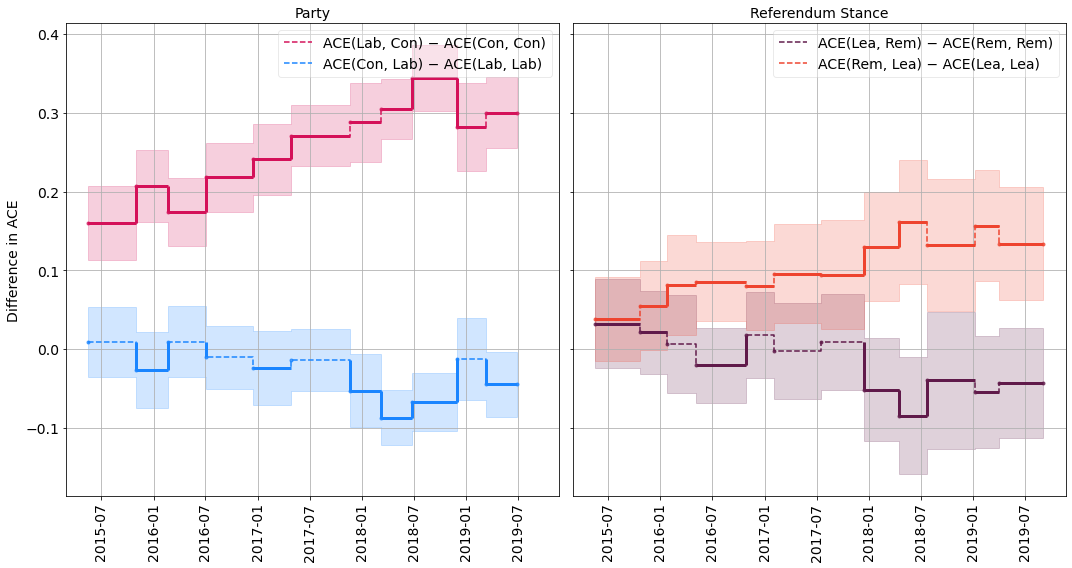

In [9]:
party_end_dates = get_ends_of_windows(os.path.join(results_fp, "conservative_labour.json"))
ref_end_dates = get_ends_of_windows(os.path.join(results_fp, "remain_leave.json"))

con_lab_diff = con_lab_runs - con_con_runs
lab_con_diff = lab_con_runs - lab_lab_runs

remain_leave_diff = remain_leave_runs - remain_remain_runs
leave_remain_diff = leave_remain_runs - leave_leave_runs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#D41159", "#1A85FF", "#601A4A", "#EE442F"]

means = con_lab_diff.mean(axis=1)
stds = con_lab_diff.std(axis=1)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(con_lab_runs, con_con_runs, party_end_dates, sig_level=0.01)]

plot_group_similarity_across_runs_stepped(means, stds, ax1, colour=colour_list[0], line_style="--", fill_alpha=0.2, label="ACE(Lab, Con) − ACE(Con, Con)", end_dates=party_end_dates, line_alpha=1)
plot_hlines(h_lines, ax1, colour_list[0])
highlight_significant_changes(con_lab_diff, party_end_dates, ax1, colour_list[0], line_alpha=0, sig_level=0.01)

means = lab_con_diff.mean(axis=1)
stds = lab_con_diff.std(axis=1)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(lab_con_runs, lab_lab_runs, party_end_dates, sig_level=0.01)]

plot_group_similarity_across_runs_stepped(means, stds, ax1, colour=colour_list[1], line_style="--", fill_alpha=0.2, label="ACE(Con, Lab) − ACE(Lab, Lab)", end_dates=party_end_dates, line_alpha=1)
plot_hlines(h_lines, ax1, colour_list[1])
highlight_significant_changes(lab_con_diff, party_end_dates, ax1, colour_list[1], line_alpha=0, sig_level=0.01)


ax1.title.set(text='Party', fontsize=14)
ax1.set_ylabel("Difference in ACE", fontsize=14)
ax1.grid()

means = remain_leave_diff.mean(axis=1)
stds = remain_leave_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax2, colour=colour_list[2], line_style="--", fill_alpha=0.2, label="ACE(Lea, Rem) − ACE(Rem, Rem)", end_dates=ref_end_dates, line_alpha=1)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(remain_leave_runs, remain_remain_runs, ref_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax2, colour_list[2])
highlight_significant_changes(remain_leave_diff, ref_end_dates, ax2, colour_list[2], line_alpha=0, sig_level=0.01)

means = leave_remain_diff.mean(axis=1)
stds = leave_remain_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax2, colour=colour_list[3], line_style="--", fill_alpha=0.2, label="ACE(Rem, Lea) − ACE(Lea, Lea)", end_dates=ref_end_dates, line_alpha=1)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(leave_remain_runs, leave_leave_runs, ref_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax2, colour_list[3])
highlight_significant_changes(leave_remain_diff, ref_end_dates, ax2, colour_list[3], line_alpha=0, sig_level=0.01)

ax2.title.set(text='Referendum Stance', fontsize=14)
ax2.grid()

ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

ax1.legend(fontsize=14, framealpha=0.4)
ax2.legend(fontsize=14, framealpha=0.4)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "Identity.pdf"))

plt.show()

The above graph is slightly confusing because it appears that Labour is divergent from the Conservatives but the Conservatives are not divergent from Labour.

This problem emerges because of Labour's high unpredictability.

In [10]:
eu_party_comparisons = get_CE_comparisons(os.path.join(results_fp_eu, "conservative_labour.json"))
eu_party_end_dates = get_ends_of_windows(os.path.join(results_fp_eu, "conservative_labour.json"))

eu_con_con_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Conservative", "Conservative")
eu_con_lab_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Conservative", "Labour")

eu_lab_con_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Labour", "Conservative")
eu_lab_lab_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Labour", "Labour")

eu_con_con_means, eu_con_con_stds = get_ce_mean_and_std(eu_party_comparisons, "Conservative", "Conservative")
eu_con_lab_means, eu_con_lab_stds = get_ce_mean_and_std(eu_party_comparisons, "Conservative", "Labour")

eu_lab_con_means, eu_lab_con_stds = get_ce_mean_and_std(eu_party_comparisons, "Labour", "Conservative")
eu_lab_lab_means, eu_lab_lab_stds = get_ce_mean_and_std(eu_party_comparisons, "Labour", "Labour")

In [11]:
eu_ref_comparisons = get_CE_comparisons(os.path.join(results_fp_eu, "remain_leave.json"))
eu_ref_end_dates = get_ends_of_windows(os.path.join(results_fp_eu, "remain_leave.json"))

eu_remain_remain_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "remain", "remain")
eu_remain_leave_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "remain", "leave")

eu_leave_remain_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "leave", "remain")
eu_leave_leave_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "leave", "leave")

eu_remain_remain_means, eu_remain_remain_stds = get_ce_mean_and_std(eu_ref_comparisons, "remain", "remain")
eu_remain_leave_means, eu_remain_leave_stds = get_ce_mean_and_std(eu_ref_comparisons, "remain", "leave")

eu_leave_remain_means, eu_leave_remain_stds = get_ce_mean_and_std(eu_ref_comparisons, "leave", "remain")
eu_leave_leave_means, eu_leave_leave_stds = get_ce_mean_and_std(eu_ref_comparisons, "leave", "leave")

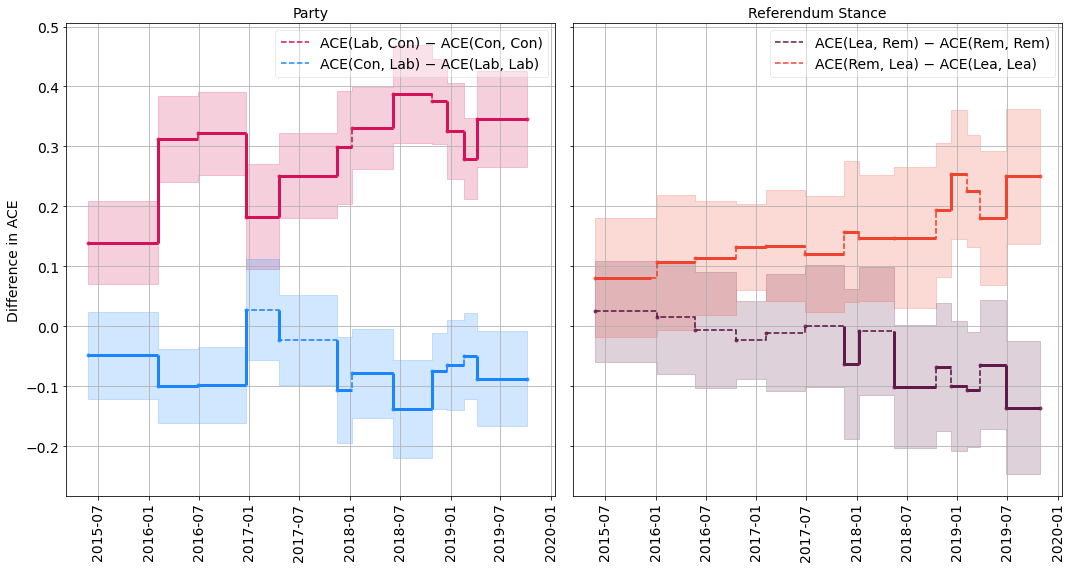

In [12]:
con_lab_diff = eu_con_lab_runs - eu_con_con_runs
lab_con_diff = eu_lab_con_runs - eu_lab_lab_runs

remain_leave_diff = eu_remain_leave_runs - eu_remain_remain_runs
leave_remain_diff = eu_leave_remain_runs - eu_leave_leave_runs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#D41159", "#1A85FF", "#601A4A", "#EE442F"]

means = con_lab_diff.mean(axis=1)
stds = con_lab_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax1, colour=colour_list[0], line_style="--", line_alpha=1, fill_alpha=0.2, label="ACE(Lab, Con) − ACE(Con, Con)", end_dates=eu_party_end_dates)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(eu_con_lab_runs, eu_con_con_runs, eu_party_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax1, colour_list[0])
highlight_significant_changes(con_lab_diff, eu_party_end_dates, ax1, colour_list[0], sig_level=0.01)

means = lab_con_diff.mean(axis=1)
stds = lab_con_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax1, colour=colour_list[1], line_style="--", line_alpha=1, fill_alpha=0.2, label="ACE(Con, Lab) − ACE(Lab, Lab)", end_dates=eu_party_end_dates)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(eu_lab_con_runs, eu_lab_lab_runs, eu_party_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax1, colour_list[1])
highlight_significant_changes(lab_con_diff, eu_party_end_dates, ax1, colour_list[1], sig_level=0.01)


ax1.title.set(text='Party', fontsize=14)
ax1.set_ylabel("Difference in ACE", fontsize=14)
ax1.grid()

means = remain_leave_diff.mean(axis=1)
stds = remain_leave_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax2, colour=colour_list[2], line_style="--", line_alpha=1, fill_alpha=0.2, label="ACE(Lea, Rem) − ACE(Rem, Rem)", end_dates=eu_ref_end_dates)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(eu_remain_leave_runs, eu_remain_remain_runs, eu_ref_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax2, colour_list[2])
highlight_significant_changes(remain_leave_diff, eu_ref_end_dates, ax2, colour_list[2], sig_level=0.01)


means = leave_remain_diff.mean(axis=1)
stds = leave_remain_diff.std(axis=1)

plot_group_similarity_across_runs_stepped(means, stds, ax2, colour=colour_list[3], line_style="--", line_alpha=2, fill_alpha=0.2, label="ACE(Rem, Lea) − ACE(Lea, Lea)", end_dates=eu_ref_end_dates)
h_lines = [[means.loc[x[1]], x[1], x[2]] for x in get_significant_windows(eu_leave_remain_runs, eu_leave_leave_runs, eu_ref_end_dates, sig_level=0.01)]
plot_hlines(h_lines, ax2, colour_list[3])
highlight_significant_changes(leave_remain_diff, eu_ref_end_dates, ax2, colour_list[3], sig_level=0.01)


ax2.title.set(text='Referendum Stance', fontsize=14)
ax2.grid()

ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

ax1.legend(fontsize=14, framealpha=0.4)
ax2.legend(fontsize=14, framealpha=0.4)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "EU_Identity.pdf"))

plt.show()

# How consistent were the groups over time?

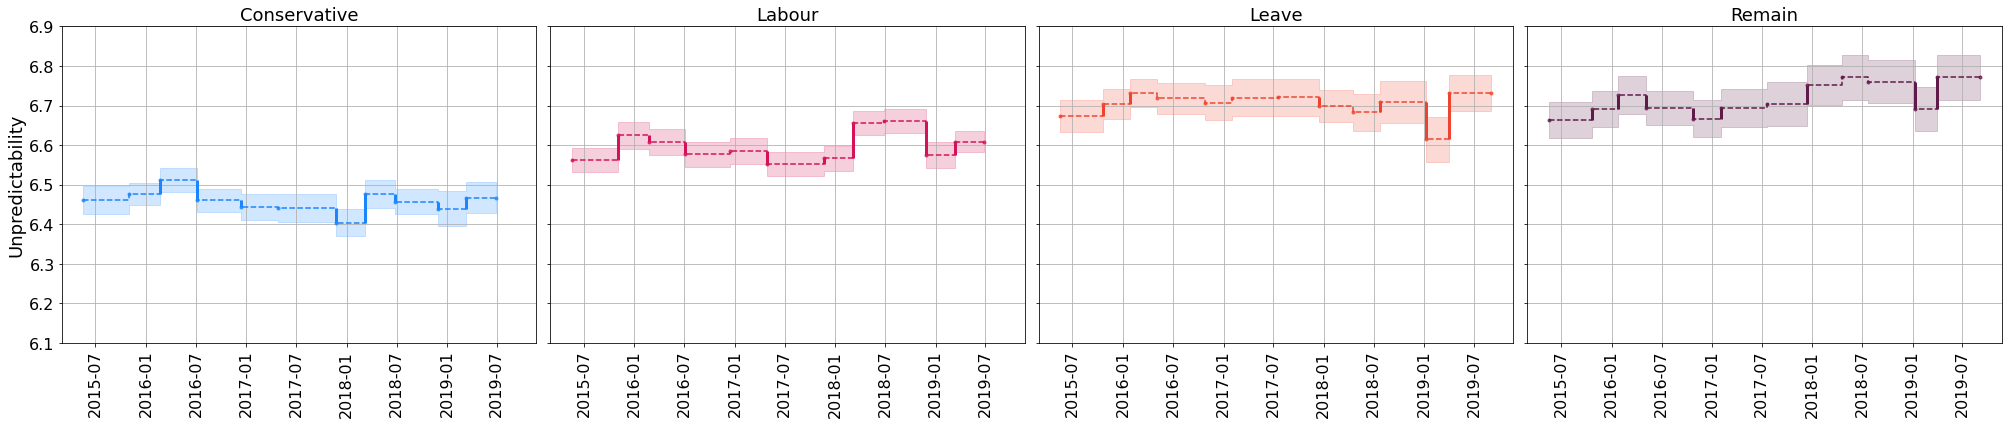

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(28, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#D41159", "#1A85FF", "#601A4A", "#EE442F"]

plot_group_similarity_across_runs_stepped(con_con_means, con_con_stds, ax1, colour=colour_list[1], line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=party_end_dates)
highlight_significant_changes(con_con_runs, party_end_dates, ax1, colour_list[1], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(lab_lab_means, lab_lab_stds, ax2, colour=colour_list[0], line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=party_end_dates)
highlight_significant_changes(lab_lab_runs, party_end_dates, ax2, colour_list[0], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(leave_leave_means, leave_leave_stds, ax3, colour=colour_list[3], line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=ref_end_dates)
highlight_significant_changes(leave_leave_runs, ref_end_dates, ax3, colour_list[3], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(remain_remain_means, remain_remain_stds, ax4, colour=colour_list[2], line_style="--", line_alpha=1, fill_alpha=0.2, end_dates=ref_end_dates)
highlight_significant_changes(remain_remain_runs, ref_end_dates, ax4, colour_list[2], line_alpha=0, sig_level=0.01)

ax1.title.set(text='Conservative', fontsize=18)
ax2.title.set(text='Labour', fontsize=18)

ax3.title.set(text='Leave', fontsize=18)
ax4.title.set(text='Remain', fontsize=18)

ax1.set_ylabel("Unpredictability", fontsize=18)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)

plt.ylim(6.1, 6.9)
plt.tight_layout()

fig.savefig(os.path.join(out_fp, "all_unpredictability.pdf"))

plt.show()

In [14]:
eu_party_comparisons = get_CE_comparisons(os.path.join(results_fp_eu, "conservative_labour.json"))
eu_party_end_dates = get_ends_of_windows(os.path.join(results_fp_eu, "conservative_labour.json"))

eu_con_con_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Conservative", "Conservative")
eu_lab_lab_runs = get_CE_means_fixed_windows(eu_party_comparisons, "Labour", "Labour")

eu_con_con_means, eu_con_con_stds = get_ce_mean_and_std(eu_party_comparisons, "Conservative", "Conservative")
eu_lab_lab_means, eu_lab_lab_stds = get_ce_mean_and_std(eu_party_comparisons, "Labour", "Labour")

eu_ref_comparisons = get_CE_comparisons(os.path.join(results_fp_eu, "remain_leave.json"))
eu_ref_end_dates = get_ends_of_windows(os.path.join(results_fp_eu, "remain_leave.json"))

eu_remain_remain_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "remain", "remain")
eu_leave_leave_runs = get_CE_means_fixed_windows(eu_ref_comparisons, "leave", "leave")

eu_remain_remain_means, eu_remain_remain_stds = get_ce_mean_and_std(eu_ref_comparisons, "remain", "remain")
eu_leave_leave_means, eu_leave_leave_stds = get_ce_mean_and_std(eu_ref_comparisons, "leave", "leave")

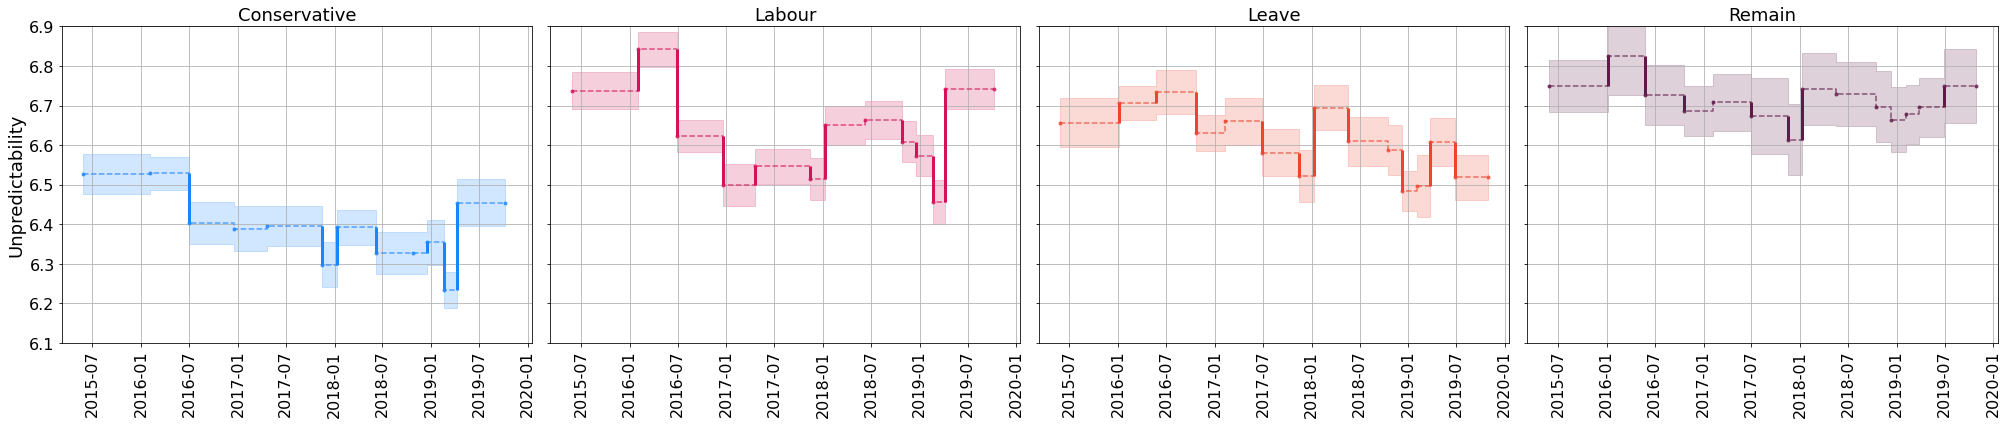

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(28, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#D41159", "#1A85FF", "#601A4A", "#EE442F"]

plot_group_similarity_across_runs_stepped(eu_con_con_means, eu_con_con_stds, ax1, colour=colour_list[1], line_style="--", line_alpha=0.7,fill_alpha=0.2, end_dates=eu_party_end_dates)
highlight_significant_changes(eu_con_con_runs, eu_party_end_dates, ax1, colour_list[1], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(eu_lab_lab_means, eu_lab_lab_stds, ax2, colour=colour_list[0], line_style="--", line_alpha=0.7,fill_alpha=0.2, end_dates=eu_party_end_dates)
highlight_significant_changes(eu_lab_lab_runs, eu_party_end_dates, ax2, colour_list[0], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(eu_leave_leave_means, eu_leave_leave_stds, ax3, colour=colour_list[3], line_style="--", line_alpha=0.7, fill_alpha=0.2, end_dates=eu_ref_end_dates)
highlight_significant_changes(eu_leave_leave_runs, eu_ref_end_dates, ax3, colour_list[3], line_alpha=0, sig_level=0.01)

plot_group_similarity_across_runs_stepped(eu_remain_remain_means, eu_remain_remain_stds, ax4, colour=colour_list[2], line_style="--", line_alpha=0.7, fill_alpha=0.2, end_dates=eu_ref_end_dates)
highlight_significant_changes(eu_remain_remain_runs, eu_ref_end_dates, ax4, colour_list[2], line_alpha=0, sig_level=0.01)


ax1.title.set(text='Conservative', fontsize=18)
ax2.title.set(text='Labour', fontsize=18)

ax3.title.set(text='Leave', fontsize=18)
ax4.title.set(text='Remain', fontsize=18)

ax1.set_ylabel("Unpredictability", fontsize=18)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)

plt.ylim(6.1, 6.9)
plt.tight_layout()

fig.savefig(os.path.join(out_fp, "eu_unpredictability.pdf"))

plt.show()

# Keywords

In [16]:
with open(os.path.join(kw_dir, "kw_against_non_eu.json")) as curr_file:
    eu_kw = json.load(curr_file)

In [17]:
kw_rcon = pd.Series(eu_kw["r_con_remainers"])
kw_lcon = pd.Series(eu_kw["l_con_remainers"])
kw_leav = pd.Series(eu_kw["leavers"])

In [18]:
def get_kw_diff_and_rank(kw1, kw2, cols):
    # Compare the local window vs ref to the global lab vs global ref.
    shared_kw = pd.concat([kw1, kw2], axis=1).dropna()
    shared_kw.columns = cols

    shared_kw["difference"] = shared_kw[cols[0]] - shared_kw[cols[1]]

    ranks1 = pd.Series(np.arange(1, len(shared_kw)+1), index=shared_kw.loc[:, cols[0]].sort_values(ascending=False).index)
    ranks2 = pd.Series(np.arange(1, len(shared_kw)+1), index=shared_kw.loc[:, cols[1]].sort_values(ascending=False).index)

    shared_kw["{} Rank".format(cols[0])] = ranks1
    shared_kw["{} Rank".format(cols[1])] = ranks2
    shared_kw["Rank Difference"] = -(shared_kw["{} Rank".format(cols[0])] - shared_kw["{} Rank".format(cols[1])])
    return shared_kw

In [19]:
kw_rcon.head(20)

brexit          13.983541
eu              13.837936
brexiteers       8.175298
ucNUMBER         7.840879
deadlock         7.089907
exiting          6.487242
streaming        6.376211
withdrawal       6.226443
confirmatory     5.819818
algorithm        5.795365
prorogued        5.750277
tusk             5.750277
revoke           5.472596
no-              4.918134
customs          4.841653
backstop         4.766075
european         4.720924
revocation       4.656119
referendum       4.430059
orderly          4.401382
dtype: float64

In [20]:
kw_leav.head(20)

eu             14.127104
brexit         13.155054
belarus         9.649294
exiting         7.823323
withdrawal      7.627625
potatoes        7.302491
ihl             6.796851
tibet           6.396313
tibetan         6.238360
exit            6.150061
custom          5.948854
precedence      5.762441
backstop        5.529477
subsection      5.512755
brussels        5.463427
european        5.302363
sheep           5.245247
predictions     5.187014
self            5.181027
referendums     5.100857
dtype: float64

In [21]:
kw_ranks = get_kw_diff_and_rank(kw_rcon, kw_leav, ["R-Con", "Leaver"])

In [22]:
kw_ranks.head(20)

,R-Con,Leaver,difference,R-Con Rank,Leaver Rank,Rank Difference
brexit,13.983541,13.155054,0.828487,1,2,1
eu,13.837936,14.127104,-0.289168,2,1,-1
exiting,6.487242,7.823323,-1.336081,3,3,0
withdrawal,6.226443,7.627625,-1.401182,4,4,0
no-,4.918134,3.897468,1.020665,5,20,15
customs,4.841653,4.653398,0.188255,6,15,9
backstop,4.766075,5.529477,-0.763402,7,6,-1
european,4.720924,5.302363,-0.581439,8,8,0
referendum,4.430059,4.692909,-0.262850,9,13,4
union,4.308022,4.735258,-0.427236,10,11,1


In [23]:
kw_ranks.head(50).sort_values("difference", ascending=False).head(20)

,R-Con,Leaver,difference,R-Con Rank,Leaver Rank,Rank Difference
citizens,2.294499,1.139439,1.155060,49,113,64
no-,4.918134,3.897468,1.020665,5,20,15
rejected,3.118989,2.119269,0.999720,25,66,41
brexit,13.983541,13.155054,0.828487,1,2,1
gNUMBER,2.465640,1.713127,0.752513,43,86,43
compromise,4.112779,3.702308,0.410471,11,25,14
deal,3.059462,2.650556,0.408906,27,55,28
prime,2.441232,2.032814,0.408418,46,72,26
vote,3.394052,3.081906,0.312146,21,40,19
tariffs,3.418011,3.118135,0.299876,19,38,19


In [24]:
kw_ranks.head(20).sort_values("Rank Difference", ascending=False).head(20)

,R-Con,Leaver,difference,R-Con Rank,Leaver Rank,Rank Difference
tariffs,3.418011,3.118135,0.299876,19,38,19
no-,4.918134,3.897468,1.020665,5,20,15
chaos,3.461707,3.485198,-0.023490,17,32,15
compromise,4.112779,3.702308,0.410471,11,25,14
customs,4.841653,4.653398,0.188255,6,15,9
referendum,4.430059,4.692909,-0.262850,9,13,4
negotiated,3.440174,3.916432,-0.476258,18,19,1
union,4.308022,4.735258,-0.427236,10,11,1
brexit,13.983541,13.155054,0.828487,1,2,1
european,4.720924,5.302363,-0.581439,8,8,0


In [25]:
kw_ranks = get_kw_diff_and_rank(kw_rcon, kw_lcon, ["R-Con", "L-Con"])

In [26]:
kw_ranks.head(20)

,R-Con,L-Con,difference,R-Con Rank,L-Con Rank,Rank Difference
brexit,13.983541,13.425537,0.558005,1,2,1
eu,13.837936,14.035806,-0.197870,2,1,-1
ucNUMBER,7.840879,9.067203,-1.226324,3,3,0
exiting,6.487242,7.034781,-0.547539,4,4,0
withdrawal,6.226443,6.448293,-0.221850,5,5,0
confirmatory,5.819818,5.960014,-0.140196,6,6,0
revoke,5.472596,5.070114,0.402481,7,8,1
no-,4.918134,4.587256,0.330877,8,12,4
customs,4.841653,4.454668,0.386985,9,14,5
backstop,4.766075,3.410290,1.355785,10,30,20


In [27]:
kw_ranks.head(50).sort_values("Rank Difference", ascending=False).head(20)

,R-Con,L-Con,difference,R-Con Rank,L-Con Rank,Rank Difference
successor,2.950108,1.623178,1.326930,38,105,67
crash,2.990816,1.915425,1.075391,35,85,50
tariffs,3.418011,2.244704,1.173307,23,67,44
chaos,3.461707,2.497347,0.964360,21,55,34
nationals,3.023256,2.366536,0.656720,34,63,29
wto,3.658354,2.838384,0.819970,19,43,24
motions,2.971142,2.390925,0.580217,36,60,24
votes,2.701549,2.215680,0.485869,47,69,22
backstop,4.766075,3.410290,1.355785,10,30,20
motion,2.638041,2.219928,0.418113,49,68,19


## KW of Lab/Con 2019 Dip

In [28]:
with open(os.path.join(kw_dir, "2019_party_dip_kw_v_before.json")) as curr_file:
    kw = json.load(curr_file)

In [29]:
lab_kw = pd.Series(kw["lab"])
con_kw = pd.Series(kw["con"])

In [30]:
lab_kw.head(20)

confirmatory     7.524068
eurotunnel       6.528016
fertilisers      5.761967
indicative       5.464967
beckett          4.599588
extension        4.405495
propositions     4.272843
registrations    4.268102
pubs             4.224456
organic          4.157070
grantham         4.149987
pub              3.806197
beer             3.724076
deadlock         3.656172
fracking         3.599028
honda            3.547238
si               3.509951
packaging        3.508830
impasse          3.404633
letwin           3.374073
dtype: float64

In [31]:
con_kw.head(20)

organics          9.167308
geo-              8.660348
echa              8.608818
ammonium          8.036911
nitrate           7.299946
interpretative    7.061513
fsa               6.625414
fertiliser        6.527898
fsma              6.359953
organic           6.119128
fertilisers       5.954948
confirmatory      5.459726
hse               5.340867
eurotunnel        5.126116
h                 4.794291
extension         4.784154
operable          4.727294
gm                4.701927
redruth           4.349685
camborne          4.289564
dtype: float64

In [32]:
with open(os.path.join(kw_dir, "2019_party_dip_kw_change.json")) as curr_file:
    kw = json.load(curr_file)

In [33]:
lab_kw = pd.Series(kw["lab"])
con_kw = pd.Series(kw["con"])

In [34]:
lab_kw.head(20)

yellowhammer    6.362381
iran            6.044411
circuses        5.920676
termination     5.876954
grenfell        5.635946
visa            5.469296
prorogued       5.469296
maraviroc       5.346440
refugees        5.346440
nazanin         5.280851
algorithms      5.280851
cladding        5.280851
pml             5.212138
affordable      5.139989
operatives      5.064040
mutuals         5.064040
prorogation     4.983869
algorithm       4.983869
syria           4.983869
thomas          4.983869
dtype: float64

In [35]:
con_kw.head(20)

hong           7.278245
kong           7.278245
students       5.954724
luton          5.922484
belarus        5.654550
iranian        5.531694
tibet          5.531694
saudi          5.466105
mortgage       5.466105
ucNUMBER       5.466105
trafficking    5.397392
october        5.335074
ets            5.249294
worst-         5.169123
tibetan        5.084235
horizon        5.084235
buses          4.994037
arabia         4.994037
bridgend       4.994037
tensions       4.897821
dtype: float64